In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/galaxy-zoo-the-galaxy-challenge/all_ones_benchmark.zip
/kaggle/input/galaxy-zoo-the-galaxy-challenge/images_test_rev1.zip
/kaggle/input/galaxy-zoo-the-galaxy-challenge/central_pixel_benchmark.zip
/kaggle/input/galaxy-zoo-the-galaxy-challenge/images_training_rev1.zip
/kaggle/input/galaxy-zoo-the-galaxy-challenge/all_zeros_benchmark.zip
/kaggle/input/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.zip


In [2]:
import math
from pathlib import Path
import random
import timeit

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import polars
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
from pathlib import Path
import zipfile
import polars as pl  # Make sure to have Polars installed

# Define the base data folder
data_folder = Path("../data")

# Unzipping each file
zip_files = [
    "/kaggle/input/galaxy-zoo-the-galaxy-challenge/images_training_rev1.zip",
    "/kaggle/input/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.zip"
]

# Unzipping into the specified directory
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(data_folder)

# Define paths
img_path = data_folder / "images_training_rev1"
train_sol_path = data_folder / "training_solutions_rev1.csv"  # Adjusted for single CSV file after unzipping

# List all JPG files
file_list = sorted([str(path) for path in img_path.glob('*.jpg')])
print(f"Number of images: {len(file_list)}")

# Load the training solutions CSV file
train_sol = pl.read_csv(train_sol_path)
print("Some labels: ")
print(train_sol.head())


Number of images: 61578
Some labels: 
shape: (5, 38)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ GalaxyID ┆ Class1.1 ┆ Class1.2 ┆ Class1.3 ┆ … ┆ Class11.3 ┆ Class11.4 ┆ Class11.5 ┆ Class11.6 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 100008   ┆ 0.383147 ┆ 0.616853 ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.325512  │
│ 100023   ┆ 0.327001 ┆ 0.663777 ┆ 0.009222 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 100053   ┆ 0.765717 ┆ 0.177352 ┆ 0.056931 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 100078   ┆ 0.693377 ┆ 0.238564 ┆ 0.068059 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 100090   ┆ 0.933839 ┆ 0.0      ┆ 0.066161 ┆ … ┆ 0.0       ┆ 0.0

In [4]:
SUBCLASS_LEN = [3, 2, 2, 2, 4, 2, 3, 7, 3, 3, 6]
SUBCLASS_LEN_CUMSUM = np.cumsum(SUBCLASS_LEN)
CLASS_LEN = len(SUBCLASS_LEN)

In [5]:
soft_labels = train_sol[:, 1:].to_numpy()

one_hot_labels = np.argmax(soft_labels[:, :SUBCLASS_LEN_CUMSUM[0]], axis=1)    # Class one
for i in range(1, CLASS_LEN):
    one_hot_labels = np.vstack(
        (one_hot_labels, np.argmax(soft_labels[:, SUBCLASS_LEN_CUMSUM[i - 1]:SUBCLASS_LEN_CUMSUM[i]], axis=1))
    )
one_hot_labels = one_hot_labels.T
print(soft_labels)
print(soft_labels.shape)
print(one_hot_labels)
print(one_hot_labels.shape)

[[0.383147   0.616853   0.         ... 0.         0.         0.32551225]
 [0.327001   0.663777   0.009222   ... 0.         0.         0.        ]
 [0.765717   0.177352   0.056931   ... 0.         0.         0.        ]
 ...
 [0.202841   0.777376   0.019783   ... 0.         0.         0.07229626]
 [0.091      0.909      0.         ... 0.02306456 0.         0.04533378]
 [0.767      0.14       0.093      ... 0.         0.         0.02338   ]]
(61578, 37)
[[1 1 1 ... 0 0 5]
 [1 1 0 ... 2 2 1]
 [0 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 1 5]
 [1 1 1 ... 0 2 1]
 [0 1 1 ... 0 0 5]]
(61578, 11)


In [6]:
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        file = self.file_list[index]
        label = self.labels[index]

        image = Image.open(file)

        if self.transform is not None:
            image = self.transform(image)

        return image, label
    
    def __len__(self):
        return len(self.labels)
        
train_file_list, temp_file_list, train_soft_labels, temp_soft_labels =\
     train_test_split(file_list, soft_labels, test_size=0.1,
                      random_state=42, stratify=one_hot_labels[:, 0])

temp_one_hot_labels = np.argmax(temp_soft_labels[:, :3], axis=1)

valid_file_list, test_file_list, valid_soft_labels, test_soft_labels =\
     train_test_split(temp_file_list, temp_soft_labels, test_size=0.7,
                      random_state=42, stratify=temp_one_hot_labels)

transform_train = transforms.Compose([
    transforms.RandomRotation(360),
    transforms.CenterCrop([256, 256]),
    transforms.Resize([128, 128]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.CenterCrop([256, 256]),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = ImageDataset(train_file_list, train_soft_labels, transform_train)
valid_dataset = ImageDataset(valid_file_list, valid_soft_labels, transform)
test_dataset = ImageDataset(test_file_list, test_soft_labels, transform)

print(f"Length of training files: {len(train_file_list)}")
print(f"Length of validation files: {len(valid_file_list)}")
print(f"Length of testing files: {len(test_file_list)}")

train_one_hot_labels_class_one = np.argmax(train_soft_labels[:, :3], axis=1)
valid_one_hot_labels_class_one = np.argmax(valid_soft_labels[:, :3], axis=1)
test_one_hot_labels_class_one = np.argmax(test_soft_labels[:, :3], axis=1)

print()
print("Class 1 distribution: ")
print(f"Training dataset: {Counter(train_one_hot_labels_class_one)}")
print(f"Validation dataset: {Counter(valid_one_hot_labels_class_one)}")
print(f"Testing dataset: {Counter(test_one_hot_labels_class_one)}")

Length of training files: 55420
Length of validation files: 1847
Length of testing files: 4311

Class 1 distribution: 
Training dataset: Counter({1: 31343, 0: 24024, 2: 53})
Validation dataset: Counter({1: 1045, 0: 800, 2: 2})
Testing dataset: Counter({1: 2438, 0: 1869, 2: 4})


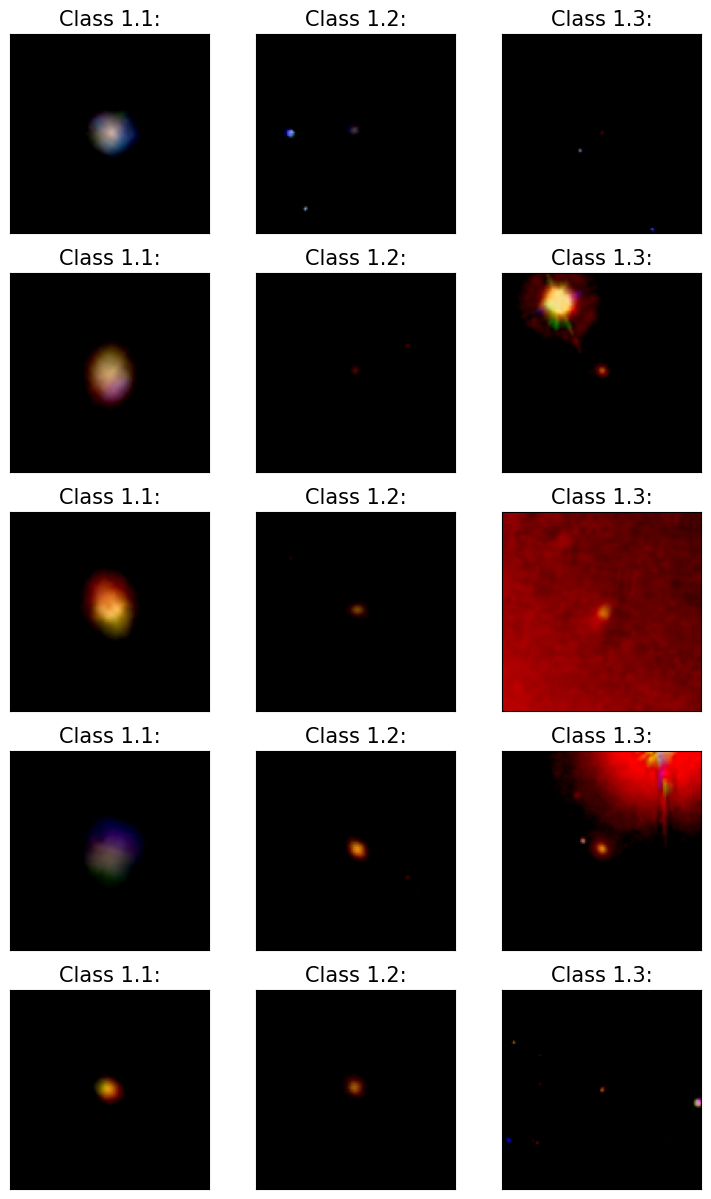

In [7]:
data_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)

img_class_zero = []
img_class_one = []
img_class_two = []
img_per_class = 5

iter_data_loader = iter(data_loader)
while True:
    img_batch, label_batch = next(iter_data_loader)
    for i in range(100):
        img = img_batch[i]
        label = label_batch[i]
        one_hot_label = np.argmax(label[:3])

        if (len(img_class_zero) < img_per_class) and (one_hot_label == 0):
            img_class_zero.append(img)
        elif (len(img_class_one) < img_per_class) and (one_hot_label == 1):
            img_class_one.append(img)
        elif (len(img_class_two) < img_per_class) and (one_hot_label == 2):
            img_class_two.append(img)
            
    if (
        (len(img_class_zero) >= img_per_class)
        and (len(img_class_one) >= img_per_class)
        and (len(img_class_two) >= img_per_class)
    ):
        break

fig1 = plt.figure(figsize=(9, 15))
for i in range(img_per_class):
    img = img_class_zero[i].cpu()
    ax = fig1.add_subplot(img_per_class, 3, (i * 3) + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Class 1.1:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_class_one[i].cpu()
    ax = fig1.add_subplot(img_per_class, 3, (i * 3) + 2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Class 1.2:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_class_two[i].cpu()
    ax = fig1.add_subplot(img_per_class, 3, (i * 3) + 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Class 1.3:', size=15)
    ax.imshow(img.permute(1, 2, 0))

plt.show()

In [8]:
import torch.optim as optim
from torchvision import models

# Load a pretrained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the final layer to match the number of classes
num_classes = one_hot_labels.shape[1]  # Set to the number of your one-hot classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s] 


In [9]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
# Set up optimizer, loss function, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [11]:
# Set num_classes to match the number of columns in one_hot_labels
num_classes = soft_labels.shape[1]
model.fc = nn.Linear(model.fc.in_features, num_classes)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
def train_model(model, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, save_every_n_epochs=5):
    model.to(device)  # Move the model to the device
    model.train()
    train_loss_hist = []
    valid_loss_hist = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, torch.argmax(labels, dim=1))  # Ensure labels are in correct format
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_loss_hist.append(train_loss)
        
        # Validation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
                outputs = model(images)
                loss = criterion(outputs, torch.argmax(labels, dim=1))
                valid_loss += loss.item() * images.size(0)
                
        valid_loss /= len(valid_loader.dataset)
        valid_loss_hist.append(valid_loss)
        
        # Adjust learning rate
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

        # Save checkpoint
        if (epoch + 1) % save_every_n_epochs == 0:
            torch.save(model.state_dict(), f'resnet50_epoch{epoch+1}.pth')

    return train_loss_hist, valid_loss_hist


In [14]:
num_epochs = 5
train_loss_hist, valid_loss_hist = train_model(model, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader)

Epoch [1/5], Train Loss: 0.7423, Valid Loss: 0.6082
Epoch [2/5], Train Loss: 0.9441, Valid Loss: 0.8340
Epoch [3/5], Train Loss: 0.7603, Valid Loss: 0.6661
Epoch [4/5], Train Loss: 0.6388, Valid Loss: 0.5831
Epoch [5/5], Train Loss: 0.6027, Valid Loss: 0.5603


In [15]:
def plot_losses_and_lr(train_loss_hist, valid_loss_hist):
    epochs = range(1, len(train_loss_hist) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_hist, label='Train Loss', color='blue')
    plt.plot(epochs, valid_loss_hist, label='Valid Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

#     # Plot learning rate
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, lr_hist, label='Learning Rate', color='green')
#     plt.title('Learning Rate Over Epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('Learning Rate')
#     plt.legend()

    plt.tight_layout()
    plt.show()

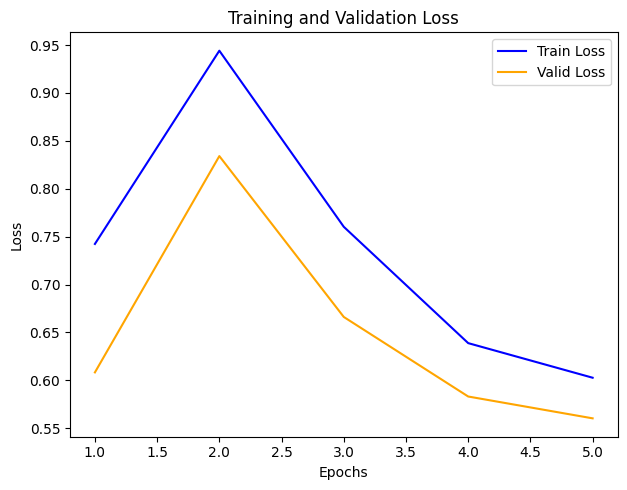

In [16]:
plot_losses_and_lr(train_loss_hist, valid_loss_hist)

In [17]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No need to calculate gradients during testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model(images)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            test_loss += loss.item() * images.size(0)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
    
    # Calculate average loss and accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = 100 * correct / total
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return test_loss, accuracy

# Example usage after training
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)


Test Loss: 0.5722, Test Accuracy: 76.80%


In [1]:
# Install PEFT library if not already installed
!pip install peft


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 6.2 MB/s eta 0:00:00a 0:00:01


In [14]:
from peft import LoraConfig, get_peft_model
from torch import nn

# Create a LoRA configuration with low-rank adaptation on selected layers.
lora_config = LoraConfig(
    r=8,                     # LoRA rank
    lora_alpha=32,           # LoRA scaling factor
    target_modules=["fc"],    # Specify the layers you want to apply LoRA to (only the final layer here)
    lora_dropout=0.1         # Dropout to apply to LoRA weights for regularization
)

# Apply the LoRA configuration to the model
model = get_peft_model(model, lora_config)

# Verify that LoRA is applied by printing the model summary
print(model)


PeftModel(
  (base_model): LoraModel(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inp

In [16]:
# Only fine-tune LoRA parameters
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
num_epochs=5
# Rest of the training process remains similar
train_loss_hist, valid_loss_hist = train_model(
    model, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader
)


Epoch [1/5], Train Loss: 0.8933, Valid Loss: 0.8227
Epoch [2/5], Train Loss: 0.8238, Valid Loss: 0.7955
Epoch [3/5], Train Loss: 0.8125, Valid Loss: 0.8186
Epoch [4/5], Train Loss: 0.8040, Valid Loss: 0.8189
Epoch [5/5], Train Loss: 0.8016, Valid Loss: 0.7823


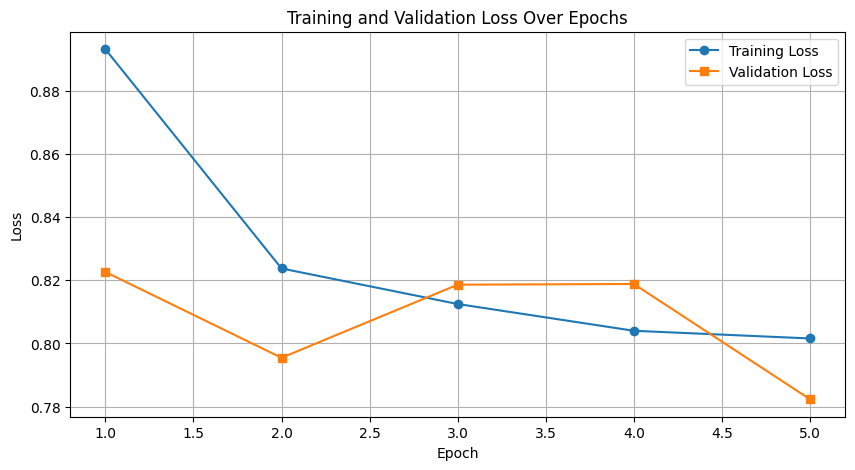

In [17]:
import matplotlib.pyplot as plt

def plot_loss(train_loss_hist, valid_loss_hist):
    epochs = len(train_loss_hist)
    plt.figure(figsize=(10, 5))
    
    # Plot training and validation loss
    plt.plot(range(1, epochs + 1), train_loss_hist, label='Training Loss', marker='o')
    plt.plot(range(1, epochs + 1), valid_loss_hist, label='Validation Loss', marker='s')
    
    # Graph labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call this function with the loss histories after training
plot_loss(train_loss_hist, valid_loss_hist)


In [19]:
def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, torch.argmax(labels, dim=1))  # Calculate the loss
            total_loss += loss.item() * images.size(0)  # Accumulate the loss
            
            # Predictions
            _, predicted = torch.max(outputs, 1)
            
            # Convert one-hot labels to class indices if needed
            if labels.ndim > 1:  
                labels = torch.argmax(labels, dim=1)
                
            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    return avg_loss, accuracy

# Call this function to test your model after training
test_loss, test_accuracy = test_model(model, test_loader, criterion)


Test Loss: 0.7645
Test Accuracy: 69.20%
